In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers.experimental import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
from tqdm import tqdm

2023-07-26 09:19:50.586327: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 09:19:50.672255: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 09:19:50.673947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 09:19:53.080439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


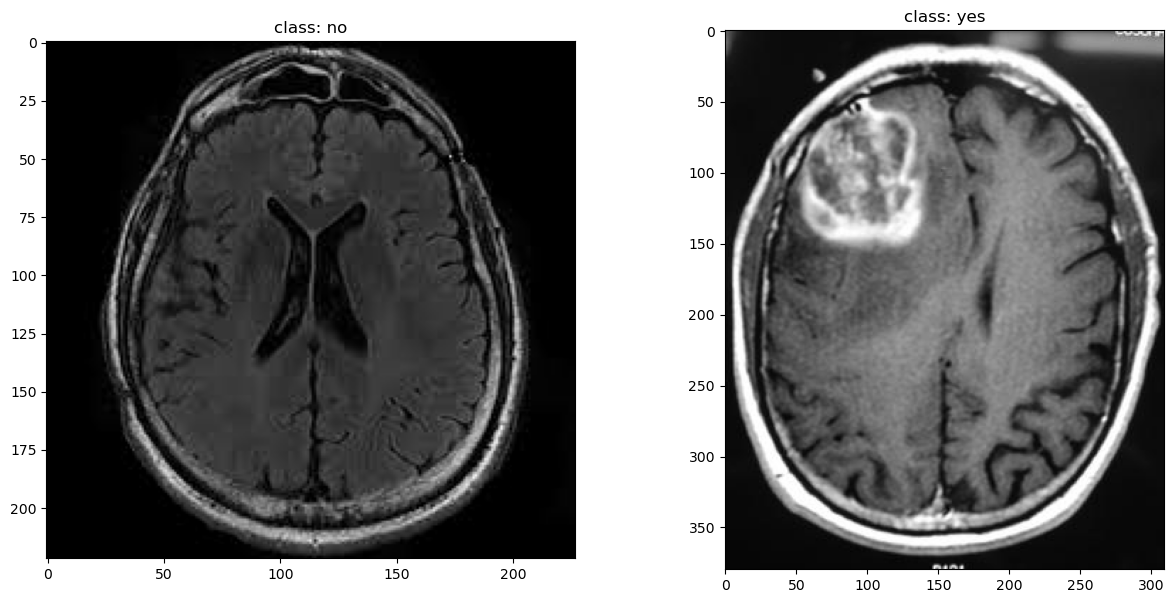

In [2]:
categories = ["no","yes"]
directory = "./data/"
fig,ax = plt.subplots(ncols=2,figsize=(15,7))
for idx,category in enumerate(categories):
    new_dir = os.path.join(directory,category)
    for image in os.listdir(new_dir):
        img_arr = cv2.imread(os.path.join(new_dir,image))
        ax[idx].imshow(img_arr)
        ax[idx].title.set_text(f"class: {category}")
        break
plt.show()

In [3]:
data = []
for idx,category in tqdm(enumerate(categories)):
    new_dir = os.path.join(directory,category)
    for image in os.listdir(new_dir):
        img_arr = cv2.imread(os.path.join(new_dir,image))
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        img_resize = cv2.resize(img_arr,(224,224))
        data.append([img_resize,idx])

0it [00:00, ?it/s]

2it [00:01,  1.73it/s]


In [4]:
for x, y in data:
    print(x.shape)
    break

(224, 224, 3)


In [5]:
check_sample=[]
for sample in data:
    check_sample.append(sample[1])
    check_first10 = check_sample[:10]
    check_last10 = check_sample[-10:]

print(f'{check_first10}\n{check_last10}')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [6]:
zeros = []
ones = []
for sample in data:
    test = sample[1]
    if test==1:
        ones.append(test)
    else:
        zeros.append(0)

print(f'There are {len(zeros)} \'no\' cases')
print(f'There are {len(ones)} \'yes\' cases')

There are 98 'no' cases
There are 155 'yes' cases


In [7]:
# data = data[:(196)]

In [8]:
zeros = []
ones = []
for sample in data:
    test = sample[1]
    if test==1:
        ones.append(test)
    else:
        zeros.append(0)

print(f'There are {len(zeros)} \'no\' cases')
print(f'There are {len(ones)} \'yes\' cases')

There are 98 'no' cases
There are 155 'yes' cases


In [9]:
import random
random.shuffle(data)

In [10]:
check_sample=[]
for sample in data:
    check_sample.append(sample[1])
check_first10 = check_sample[:10]
check_last10 = check_sample[-10:]

print(f'{check_first10}\n{check_last10}')

[0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
[1, 1, 1, 1, 0, 0, 0, 1, 1, 0]


In [11]:
X_train = []
y_train = []
for arr, cat in data:
    X_train.append(arr)
    y_train.append(cat)
X_train = np.array(X_train).reshape(-1, 224,224, 3)
y_train = np.array(y_train)

In [12]:
train_gen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=10,
                width_shift_range=0.15,
                height_shift_range=0.15,
                shear_range=0.1,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode="nearest",
                validation_split=0.2,
                   )
val_gen = ImageDataGenerator(
                rescale=1./255, 
                validation_split=0.2,
                    )


train_data = train_gen.flow(
                X_train,
                y_train,
                batch_size=32,
                seed=123,
                subset="training",
                    )
val_data = val_gen.flow(
                X_train,
                y_train,
                batch_size=16,
                seed=123,
                subset="validation"
                    )

### Visualizing first batch in the training data, just to confirm that images have been augumented

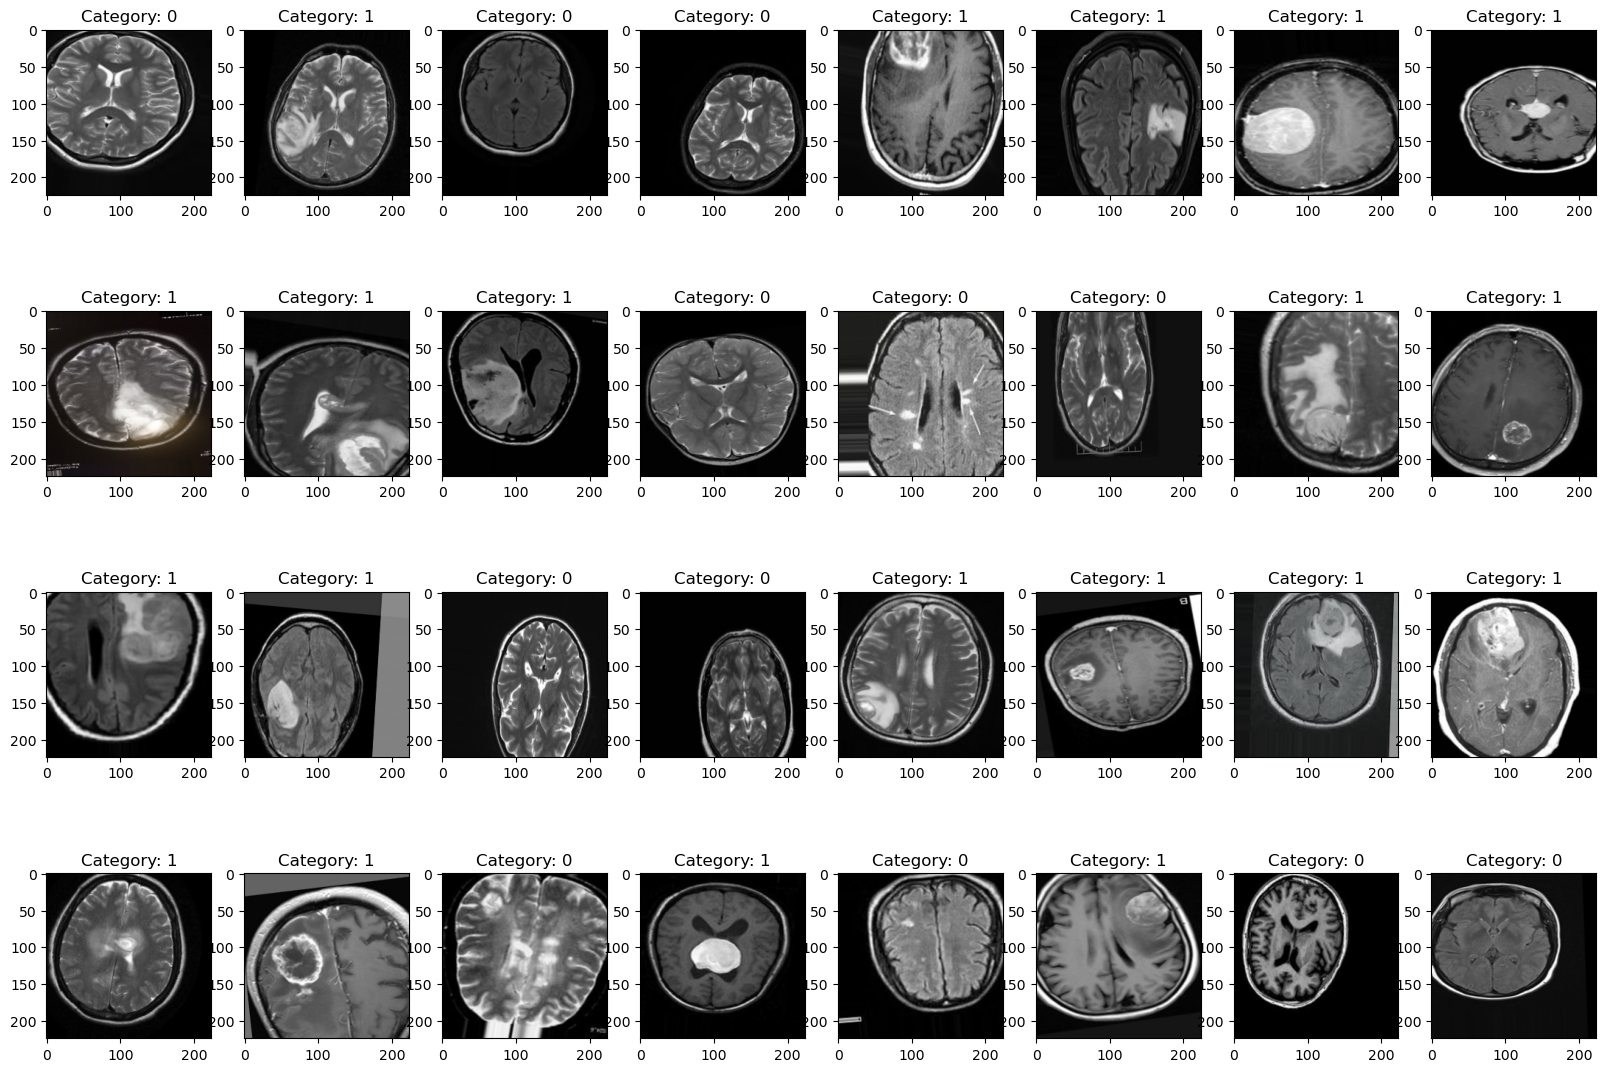

In [13]:
plt.figure(figsize=(20,14))
batch_to_plot = next(train_data)
for idx, array in enumerate(batch_to_plot[0], start=1):
    plt.subplot(4,8,idx)
    plt.imshow(array)
    plt.title(f"Category: {batch_to_plot[1][idx-1]}")
    
plt.show()


### Visualizing first batch in the validation data, just to confirm that image were not augumented

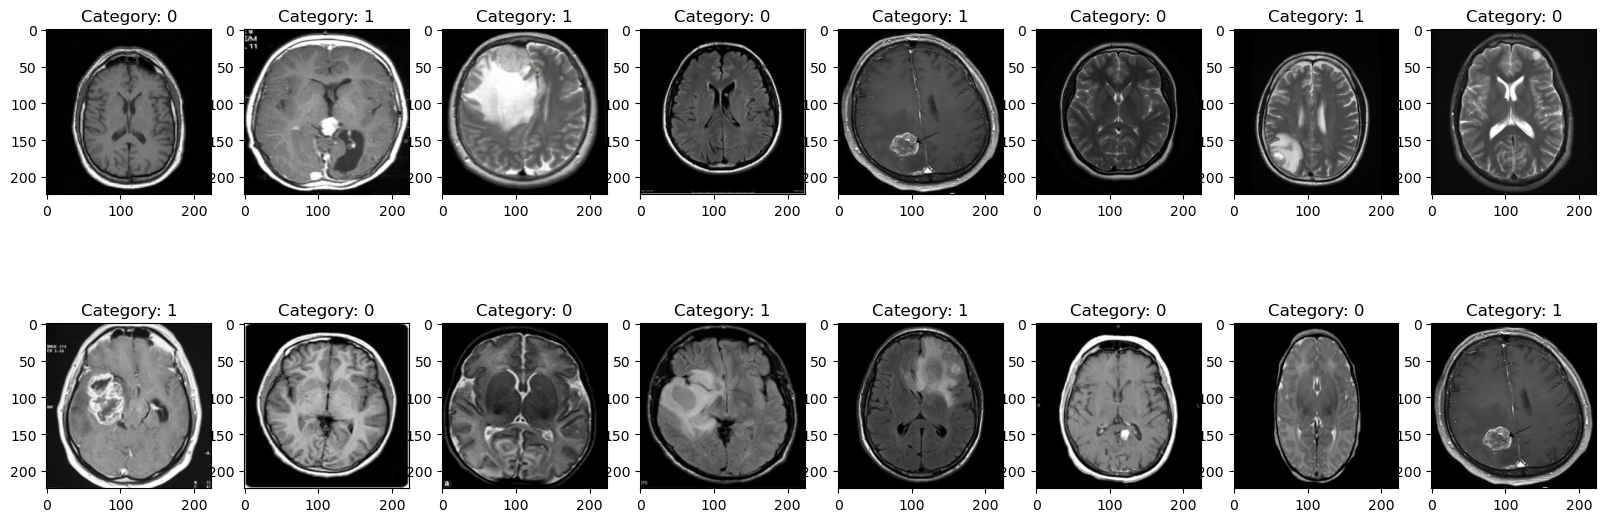

In [14]:
plt.figure(figsize=(20,7))
val_batch_to_plot = next(val_data)
for idx, array in enumerate(val_batch_to_plot[0], start=1):
    plt.subplot(2,8,idx)
    plt.imshow(array)
    plt.title(f"Category: {val_batch_to_plot[1][idx-1]}")
    
plt.show()


In [15]:
base_model = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model = Sequential()
# Add the base model
model.add(base_model)

#Add the new models
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(32, activation="relu"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          147488    
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 32)          0         
 D)                                                              
                                                                 
 dense (Dense)               (None, 2, 2, 32)          1056      
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                        

In [17]:
es = EarlyStopping(
    monitor="val_accuracy", 
    patience=2,
    verbose=0,
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(
            train_data,
            steps_per_epoch=train_data.n // train_data.batch_size,
            validation_data=val_data,
            validation_steps=val_data.n // val_data.batch_size,
            epochs=30,
            # callbacks=es
                    )

Epoch 1/30


2023-07-26 09:20:10.454817: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-07-26 09:20:10.809924: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-07-26 09:20:12.516599: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2023-07-26 09:20:13.012079: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


1/6 [====>.........................] - ETA: 1:02 - loss: 0.6844 - accuracy: 0.6250

2023-07-26 09:20:20.229476: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


6/6 [==============================] - 72s 12s/step - loss: 0.6996 - accuracy: 0.5781 - val_loss: 0.6382 - val_accuracy: 0.6250
Epoch 2/30
6/6 [==============================] - 62s 10s/step - loss: 0.6278 - accuracy: 0.6667 - val_loss: 0.5663 - val_accuracy: 0.6875
Epoch 3/30
6/6 [==============================] - 66s 12s/step - loss: 0.5684 - accuracy: 0.6842 - val_loss: 0.4783 - val_accuracy: 0.7708
Epoch 4/30
6/6 [==============================] - 77s 13s/step - loss: 0.5315 - accuracy: 0.7953 - val_loss: 0.4386 - val_accuracy: 0.7708
Epoch 5/30
6/6 [==============================] - 118s 21s/step - loss: 0.5453 - accuracy: 0.7240 - val_loss: 0.5413 - val_accuracy: 0.7500
Epoch 6/30
6/6 [==============================] - 81s 14s/step - loss: 0.4753 - accuracy: 0.7895 - val_loss: 0.4114 - val_accuracy: 0.8125
Epoch 7/30
6/6 [==============================] - 86s 15s/step - loss: 0.4183 - accuracy: 0.8421 - val_loss: 0.4221 - val_accuracy: 0.8333
Epoch 8/30
6/6 [=====================

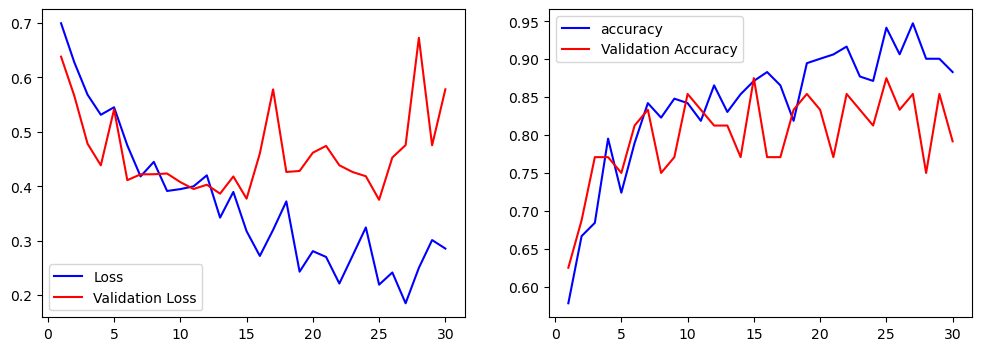

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,1+len(loss))
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(12,4))
ax1.plot(epochs,loss,'b',label='Loss')
ax1.plot(epochs,val_loss,'r',label='Validation Loss')
ax1.legend()

ax2.plot(epochs,acc,'b',label='accuracy')
ax2.plot(epochs,val_acc,'r',label='Validation Accuracy')
ax2.legend()

plt.show()


In [19]:
def predict(image_directory):
    arr = cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)
    arr_resize = cv2.resize(arr, (224, 224))
    plt.imshow(arr_resize)
    pred = model.predict(arr_resize)
    class_idx = int(pred)
    return f"Image belongs to class {categories[class_idx].upper()}"   

In [20]:
model.save("./resources/brain_mri.keras")